In [1]:
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt

## Prepare the data

In [2]:
##GG web site data
bronze_df = pd.read_csv("gg_datafiles/bronze.csv", encoding="utf-8")
gold_df = pd.read_csv("gg_datafiles/gold.csv", encoding="utf-8")
platinum_df = pd.read_csv("gg_datafiles/platinum.csv", encoding="utf-8")
platinumplus_df = pd.read_csv("gg_datafiles/platinumplus.csv", encoding="utf-8")
silver_df = pd.read_csv("gg_datafiles/silver.csv", encoding="utf-8")

In [ ]:
####Time course data
TC_data_columns_df = pd.read_csv("Timecourse_Datafiles/_columns.csv", encoding="utf-8")
TC_data_bans_df = pd.read_csv("Timecourse_Datafiles/bans.csv", encoding="utf-8")
TC_data_kills_df = pd.read_csv("Timecourse_Datafiles/kills.csv", encoding="utf-8")
TC_data_LeagueofLegends_df = pd.read_csv("Timecourse_Datafiles/LeagueofLegends.csv", encoding="utf-8")
TC_data_matchinfo_df = pd.read_csv("Timecourse_Datafiles/matchinfo.csv", encoding="utf-8")
TC_data_structures_df = pd.read_csv("Timecourse_Datafiles/structures.csv", encoding="utf-8")

In [3]:
#Create a new column to specify the league for stacking the dataset
bronze_df["League"] = "Bronze"
gold_df["League"] = "Gold"
platinum_df["League"] = "Platinum"
platinumplus_df["League"] = "Platinum Plus"
silver_df["League"] = "Silver"

#Create stacked combined dataset
stack_df = pd.concat([bronze_df, 
                      gold_df, 
                      platinum_df, 
                      platinumplus_df,
                      silver_df], axis = 0)

## Explore the data
### Describe the dataset

In [4]:
#Columns in the dataset
stack_df.columns

Index(['Rank', 'Champion', 'Role', 'Win Percent', 'Play Percent', 'Ban Rate',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change', 'League'],
      dtype='object')

In [5]:
#Search for null values, number of non-null values, data types
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   989 non-null    object 
 1   Champion               979 non-null    object 
 2   Role                   979 non-null    object 
 3   Win Percent            979 non-null    object 
 4   Play Percent           979 non-null    object 
 5   Ban Rate               979 non-null    object 
 6   Playerbase Avg. Games  898 non-null    float64
 7   Kills                  979 non-null    float64
 8   Deaths                 979 non-null    float64
 9   Assists                979 non-null    float64
 10  Largest Killing Spree  979 non-null    float64
 11  Damage Dealt           979 non-null    float64
 12  Damage Taken           979 non-null    float64
 13  Total Healing          979 non-null    float64
 14  Minions Killed         979 non-null    float64
 15  Enemy 

In [6]:
#Identify Null Values
df_null = stack_df[stack_df.isnull().any(axis=1)]
df_null

,Rank,Champion,Role,Win Percent,Play Percent,Ban Rate,Playerbase Avg. Games,Kills,Deaths,Assists,...,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change,League
10,11,Aphelios,ADC,48.48%,5.24%,2.27%,NaN,6.69,6.69,7.23,...,20397.0,18356.0,3145.0,167.2,2.50,8.29,11726.0,16.0,2.0,Bronze
64,65,Kai'Sa,ADC,47.90%,7.35%,0.31%,NaN,7.75,6.12,6.97,...,19541.0,19523.0,4109.0,170.8,2.43,8.01,12177.0,10.0,2.0,Bronze
100,101,Neeko,Middle,52.12%,1.60%,0.12%,NaN,6.28,6.09,8.02,...,20076.0,18756.0,2326.0,140.4,1.29,2.93,10684.0,34.0,2.0,Bronze
101,102,Neeko,Support,50.99%,0.98%,0.12%,NaN,3.69,6.00,7.80,...,12929.0,14498.0,1377.0,49.6,0.52,0.89,8024.0,34.0,2.0,Bronze
118,119,Pyke,Support,48.24%,5.91%,2.07%,NaN,6.60,6.79,8.04,...,10037.0,18962.0,4607.0,36.1,0.27,0.30,10454.0,8.0,1.0,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,139,Sylas,Top,43.78%,1.00%,1.61%,NaN,6.35,6.73,6.11,...,19669.0,30434.0,9107.0,138.6,1.67,3.36,10650.0,41.0,0.0,Silver
179,180,Yuumi,Support,49.99%,7.97%,3.39%,NaN,1.61,3.66,14.53,...,8348.0,7408.0,14366.0,6.7,0.09,0.13,7344.0,1.0,0.0,Silver
184,185,Zoe,Middle,46.81%,1.85%,0.31%,NaN,6.62,5.65,7.17,...,22144.0,18366.0,3515.0,145.4,0.86,3.64,10826.0,32.0,0.0,Silver
186,Champion.gg isn't endorsed by Riot Games and d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Silver


In [7]:
#Drop weird rows with no Champion listed & check non-null values
df2 = stack_df.dropna(subset = ['Champion'])
df2.info()

## === Notice that playerbase avg games still has less data (898) === ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 185
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   979 non-null    object 
 1   Champion               979 non-null    object 
 2   Role                   979 non-null    object 
 3   Win Percent            979 non-null    object 
 4   Play Percent           979 non-null    object 
 5   Ban Rate               979 non-null    object 
 6   Playerbase Avg. Games  898 non-null    float64
 7   Kills                  979 non-null    float64
 8   Deaths                 979 non-null    float64
 9   Assists                979 non-null    float64
 10  Largest Killing Spree  979 non-null    float64
 11  Damage Dealt           979 non-null    float64
 12  Damage Taken           979 non-null    float64
 13  Total Healing          979 non-null    float64
 14  Minions Killed         979 non-null    float64
 15  Enemy 

In [8]:
#Percentage values showing up as OBJECTS, 
#problematic, need to remove the % for calculations!
champ_df = df2.groupby(["Champion"]).mean()
champ_df.head()

## === Notice there are NO stats for these metrics ==== ##

,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
Champion,,,,,,,,,,,,,,
Aatrox,8.174286,4.644286,4.957143,4.828571,6.000000,15734.857143,26087.000000,10089.857143,141.042857,2.104286,3.094286,9579.00,31.714286,2.714286
Ahri,8.608333,6.106667,5.121667,7.061667,6.666667,18547.666667,17217.333333,3221.166667,142.950000,0.858333,2.855000,10288.50,20.500000,5.166667
Akali,12.318333,6.916667,5.678333,4.551667,7.500000,17378.416667,22477.916667,6146.250000,142.008333,1.011667,1.869167,10186.75,40.000000,2.250000
Alistar,3.300000,1.910000,5.650000,12.508000,3.800000,7564.200000,20848.200000,8914.200000,30.640000,0.076000,0.108000,7387.20,26.600000,4.200000
Amumu,2.844000,4.554000,5.704000,9.666000,6.800000,13318.600000,26994.400000,7621.200000,32.500000,6.590000,80.366000,10134.60,28.400000,1.600000


In [9]:
#Create a function to convert percent to float
def convert_percent(val):
    """
    Convert the percentage string to an actual floating point percent
    - Remove %
    - Divide by 100 to make decimal
    """
    new_val = val.replace('%', '')
    return float(new_val) / 100

In [10]:
# Created a new column that applies the function to convert percentage to float
# See below for alternative method that did NOT work, I am not sure why though

df2['win_percent'] = df2["Win Percent"].apply(convert_percent)
df2['ban_rate'] = df2["Ban Rate"].apply(convert_percent)
df2['play_percent'] = df2["Play Percent"].apply(convert_percent)

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [11]:
# Drop extra columns
df2.drop(columns=['Win Percent', 'Play Percent', 'Ban Rate'])

,Rank,Champion,Role,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,...,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change,League,win_percent,ban_rate,play_percent
0,1,Aatrox,Top,2.58,5.49,5.90,5.96,7.0,18687.0,31430.0,...,146.8,2.52,3.66,10685.0,35.0,1.0,Bronze,0.4690,0.0042,0.0206
1,2,Ahri,Middle,2.91,6.82,5.69,7.73,7.0,20593.0,18989.0,...,140.2,0.85,2.83,10769.0,20.0,3.0,Bronze,0.5184,0.0030,0.0333
2,3,Akali,Middle,2.98,8.45,6.61,5.48,10.0,19250.0,25051.0,...,133.9,1.16,2.28,10933.0,40.0,2.0,Bronze,0.4379,0.0077,0.0349
3,4,Akali,Top,3.98,7.21,6.06,4.82,7.0,19055.0,24429.0,...,145.3,1.18,1.71,10718.0,40.0,0.0,Bronze,0.4667,0.0077,0.0127
4,5,Alistar,Support,2.41,2.02,5.84,12.80,4.0,7948.0,21527.0,...,30.8,0.10,0.13,7501.0,22.0,6.0,Bronze,0.5176,0.0007,0.0243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,182,Zed,Middle,2.76,9.09,6.41,5.59,9.0,22524.0,21230.0,...,158.1,1.90,3.69,12116.0,1.0,0.0,Silver,0.4846,0.0316,0.0455
182,183,Ziggs,Middle,2.81,5.58,5.55,7.71,8.0,25282.0,16238.0,...,170.2,1.47,5.08,11412.0,27.0,0.0,Silver,0.4834,0.0002,0.0102
183,184,Zilean,Support,3.05,2.57,5.03,11.44,4.0,11799.0,15014.0,...,41.8,0.36,0.53,8124.0,19.0,0.0,Silver,0.5121,0.0012,0.0174
184,185,Zoe,Middle,NaN,6.62,5.65,7.17,8.0,22144.0,18366.0,...,145.4,0.86,3.64,10826.0,32.0,0.0,Silver,0.4681,0.0031,0.0185


In [ ]:
# Attempted to convert this way but didn't change the values from objects to floats for some reason
# df2['Win Percent'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2['Play Percent'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2['Ban Rate'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2.dtypes

In [12]:
#Reorder columns
df2.columns
df2 = df2.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
       'win_percent', 'ban_rate', 'play_percent',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change'])
df2.head()

,Rank,Champion,Role,League,win_percent,ban_rate,play_percent,Playerbase Avg. Games,Kills,Deaths,...,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
0,1,Aatrox,Top,Bronze,0.4690,0.0042,0.0206,2.58,5.49,5.90,...,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0
1,2,Ahri,Middle,Bronze,0.5184,0.0030,0.0333,2.91,6.82,5.69,...,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0
2,3,Akali,Middle,Bronze,0.4379,0.0077,0.0349,2.98,8.45,6.61,...,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0
3,4,Akali,Top,Bronze,0.4667,0.0077,0.0127,3.98,7.21,6.06,...,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0
4,5,Alistar,Support,Bronze,0.5176,0.0007,0.0243,2.41,2.02,5.84,...,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0


## Compare the Leagues

In [13]:
#Number of unique champions per league
league_df_champ = df2.groupby(["League"]).nunique()["Champion"]
league_df_champ

League
Bronze           148
Gold             140
Platinum         146
Platinum Plus    148
Silver           146
Name: Champion, dtype: int64

In [14]:
#Number of Roles
league_df_role = df2.groupby(["League"]).nunique()["Role"]
league_df_role

League
Bronze           5
Gold             5
Platinum         5
Platinum Plus    5
Silver           5
Name: Role, dtype: int64

In [15]:
#Number of champions in each role
league_df_champ_role = df2.groupby(["League", "Champion"]).nunique()["Role"]

league_df_champ_role

League  Champion
Bronze  Aatrox      1
        Ahri        1
        Akali       2
        Alistar     1
        Amumu       1
                   ..
Silver  Zed         1
        Ziggs       1
        Zilean      1
        Zoe         1
        Zyra        1
Name: Role, Length: 728, dtype: int64

In [16]:
roles = df2.groupby(["League", "Role"]).count()["Rank"].reset_index()
leagues = df2['League'].unique().tolist()
champion = df2['Champion'].unique().tolist()

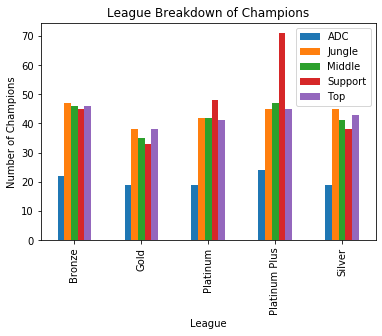

In [17]:
#Create a graph that shows the number of Champions per Role with League as the X axis
role_chart = df2.groupby(["League", "Role"]).count()["Rank"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Number of Champions")
plt.title("League Breakdown of Champions")
plt.legend(loc="best")
plt.show()

In [ ]:
#Create a graph that shows the number of Champions per Role with League as the X axis


In [ ]:
#Most popular champion
avg_2 = df2.groupby(stack_df["Champion"]).mean()
pop_champ = avg_2.sort_values(by=["Playerbase Avg. Games"],ascending = False)["Playerbase Avg. Games"]
top_10 = pop_champ.head(10)
top_10 = pd.DataFrame(top_10).reset_index()
x_axis = top_10["Champion"]
y_axis = top_10["Playerbase Avg. Games"]

plt.bar(x_axis, y_axis, color = 'purple', alpha=0.5)
plt.title("Top 10 Most Popular Champions")
plt.ylabel("Playerbase Average Games")
plt.xticks(x_axis, rotation="vertical")
plt.show()